In [1]:
import os

def load_data_by_dimension(dimension, dataset_path=""):
    root = os.path.join(dataset_path, "./datasets/") 
    data_filename = root + f'kryptonite-{dimension}-X.npy'
    labels_filename = root + f'kryptonite-{dimension}-y.npy'

    data = np.load(data_filename)
    labels = np.load(labels_filename)
    print(f"Loaded dataset with dimension {dimension}. Data shape: {data.shape}, Labels shape: {labels.shape}")
    return data, labels

In [6]:
# feature aggregation and grouping.
# Grouping Criteria: variance
# Aggregation Function: mean
import numpy as np
def load_aggregated_data(dimension, bincount, dataset_path=""): 
    data, labels = load_data_by_dimension(dimension, dataset_path)
    if data is not None:
        v = np.var(data, axis=0)
        index = np.argsort(v)
        l = len(index)//bincount
        bins = [[]for _ in range(bincount)]
        r = len(index)%bincount != 0
        for i in range(bincount):
            bins[i].extend(index[i*l:i*l+l])
        if r != 0:
            bins.append(index[-r:])
        n = []
        for b in bins:
            temp = []
            for column_index in b:
                temp.append(data[:,column_index])
            temp = np.array(temp)
            temp = np.mean(temp, axis=0)
            n.append(temp)
        n = np.array(n)
        data = n.transpose()
    return data, labels

def load_reduced_data(dimension, portion, dataset_path=""): 
    data, labels = load_data_by_dimension(dimension, dataset_path)
    if data is not None:
        v = np.var(data, axis=0)
        index = np.argsort(v)
        n = []
        l = len(index)
        for i in range(0,l-l//portion):
            n.append(data[:,i])
        n = np.array(n)
        data = n.transpose()
    return data, labels

In [8]:
import time
from datetime import datetime
from ray import train, tune
from ray.tune.search.optuna import OptunaSearch
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

cs = {
    "layer_width": tune.randint(4, 16),
    "layer_depth": tune.randint(2, 5),
    "activation": tune.choice(['relu','tanh','logistic']),
    "lr": tune.loguniform(1e-4, 1e-2), "momentum": tune.uniform(0.1, 0.9),
    "preprocess": tune.choice(['base', 'reduced']),
    "portion": tune.choice([1/3, 1/4, 1/5])
# activation="relu",
# solver = "adam",
# alpha = 0.0001,
# batch_size = "auto",
# learning_rate = "constant",
# learning_rate_init = 0.001,
# power_t = 0.5,
# max_iter = 200,
# shuffle = True,
# random_state = None,
# tol = 1e-4,
# verbose = False,
# warm_start = False,
# momentum = 0.9,
# nesterovs_momentum = True,
# early_stopping = False,
# validation_fraction = 0.1,
# beta_1 = 0.9,
# beta_2 = 0.999,
# epsilon = 1e-8,
# n_iter_no_change = 10,
# max_fun = 15000,
}

def objective(config):
    if config["preprocess"] == "aggregated":
        data, labels = load_aggregated_data(objective.dim, 3, objective.dataset_path)
    elif config["preprocess"] == "reduced":
        data, labels = load_reduced_data(objective.dim, config["portion"], objective.dataset_path)
    else:
        data, labels = load_data_by_dimension(objective.dim, objective.dataset_path)
    print(data.shape)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
    layers = [config["layer_width"]*config["layer_depth"]]
    model = MLPClassifier(hidden_layer_sizes=layers, max_iter=1000, activation=config["activation"], learning_rate_init=config["lr"], momentum=config["momentum"])
    while True:
        model.fit(X_train, y_train)
        acc = model.score(X_test, y_test)
        train.report({"mean_accuracy": acc})  # Report to Tune

In [9]:
# hyperparameter search
def search(dim):
    algo = OptunaSearch()
    objective.dim = dim
    objective.dataset_path = os.getcwd()
    tuner = tune.Tuner(
        objective,
        tune_config=tune.TuneConfig(
            metric="mean_accuracy",
            mode="max",
            search_alg=algo,
            num_samples=-1,
            time_budget_s=60 * 3,
            trial_dirname_creator=lambda x: datetime.now().strftime("%H_%M_%S")
        ),
        run_config=train.RunConfig(
            storage_path=os.path.join(os.getcwd(), "./results"),
            name="simpleneuralnetwork",
            verbose=0,
        ),
        param_space=cs,
    )
    begin = time.time()
    results = tuner.fit()
    end = time.time() - begin
    best_result = results.get_best_result(metric="mean_accuracy", mode="max")
    best_config = best_result.config
    print("auto optimization finished")
    print('time for optimisation (seconds):' + str(end))
    print("Best trial config: {}".format(best_config))
    print("Best accuracy: {}".format(best_result.metrics["mean_accuracy"]))
    return best_config

2024-11-17 15:20:45,302	INFO timeout.py:54 -- Reached timeout of 120 seconds. Stopping all trials.
2024-11-17 15:20:45,477	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'F:/ICL stuffs/math for ML/repo/results/simpleneuralnetwork' in 0.1647s.
2024-11-17 15:20:55,705	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- objective_aef9ce58: FileNotFoundError('Could not fetch metrics for objective_aef9ce58: both result.json and progress.csv were not found at F:/ICL stuffs/math for ML/repo/results/simpleneuralnetwork/15_20_39')


auto optimization finished
time for optimisation (seconds):130.65732526779175
Best trial config: {'layer_width': 8, 'layer_depth': 3, 'activation': 'tanh', 'lr': 0.0005782962808722456, 'momentum': 0.8235657324057339, 'preprocess': 'aggregated', 'bincount': 3}
Best accuracy: 0.5061111111111111
Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)


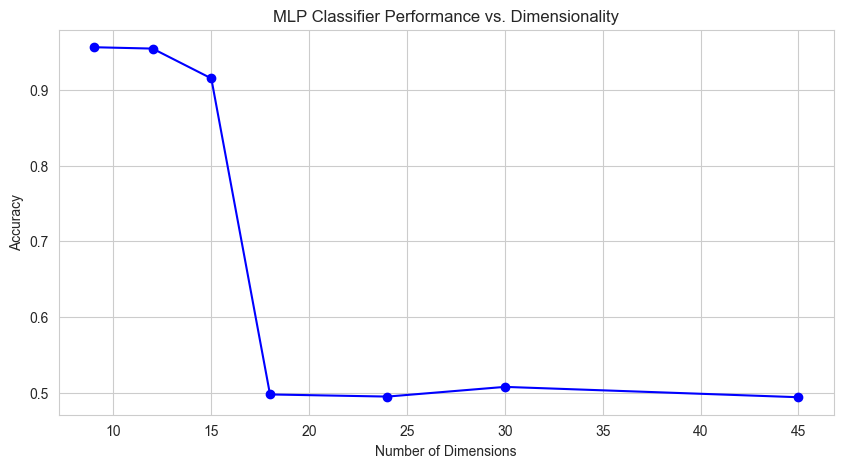

In [10]:
import numpy as np
import matplotlib.pyplot as plt

dimensions = [9, 12, 15, 18, 24, 30, 45]
best_ks = []
accuracies = []

for dim in dimensions:
    best = search(dim)
    data, labels = load_data_by_dimension(dim)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
    layers = [best["layer_width"]*best["layer_depth"]]
    model = MLPClassifier(hidden_layer_sizes=layers, max_iter=1000, activation=best["activation"],learning_rate_init=best["lr"], momentum=best["momentum"])
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    accuracies.append(accuracy)

# Plot the performance of models with their best k
plt.figure(figsize=(10, 5))
plt.plot(dimensions, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Dimensions')
plt.ylabel('Accuracy')
plt.title('MLP Classifier Performance vs. Dimensionality')
plt.grid(True)
plt.show()

In [ ]:
import seaborn as sns
n = [9, 12, 15, 18, 24, 30, 45]
target_accuracies = [0.95, 0.925, 0.9, 0.875, 0.8, 0.75, 0.7]

# Plotting settings
sns.set(style="whitegrid")
sns.set_context("poster", font_scale=0.8)
plt.figure(figsize=(10, 8))

# Plotting kNN performance
plt.plot(dimensions, accuracies, label='MLP Classifier Performance', marker='o', linestyle='-', color='b')
plt.scatter(dimensions, accuracies, color='b')

# Plotting target accuracies
plt.plot(n, target_accuracies, label='Target Accuracy', marker='o', linestyle='-', color='r')
plt.scatter(n, target_accuracies, color='r')

# Annotating target accuracies
ax = plt.gca()
for j, (x, y) in enumerate(zip(n, target_accuracies)):
  ax.text(x, y + 0.01, f'{y:.3f}', ha='left', va='bottom', color='r', size=12)
for j, (x, y) in enumerate(zip(n, accuracies)):
  ax.text(x, y + 0.01, f'{y:.3f}', ha='left', va='bottom', color='b', size=12)

# Titles and labels
plt.title("Comparison of MLP Classifier Performance vs Target Accuracies")
plt.ylabel("Accuracy")
plt.xlabel("Feature Dimension of Kryptonite-n (n)")
plt.legend()

# Show the plot
plt.show()